### imports

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

import time  # для замера времени

plt.style.use('dark_background')

### Последовательная модель

#### Первый способ создания

$$Hout= \frac{H_{in} + 2P - D \cdot (K - 1) - 1}{S} + 1$$

$$Wout=\frac{W_{in} + 2P - D \cdot (K - 1) - 1}{S} + 1$$ 

Где:

- **$H_{out}, W_{out}$** — высота и ширина выходного слоя.
- **$H_{in}, W_{in}$** — высота и ширина входного слоя.
- **$K$** — размер ядра свертки (kernel size).
- **$S$** — шаг (stride).
- **$P$** — отступы (padding).
- **$D$** — дилатация (dilation), расстояние между элементами ядра.

In [4]:
"""
    input_size = (batch_size, C, H, W)
batch_size - размер батча
C - Глубина (кол-во каналов)
H - Высота
W - Ширина
"""
# аргументы буду задавать позиционно, для лучшего понимания
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
)

model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
)

В данную модель можно подавать изображение любого размера, главное, чтобы входных каналов было 3

In [8]:
# имитация входных тензоров
input_1 = torch.rand([16, 3, 28, 28], dtype=torch.float32)
input_2 = torch.rand([16, 3, 288, 228], dtype=torch.float32)

# подача тензоров в модель
out_1 = model(input_1)
out_2 = model(input_2)

# вывод итоговых размеров тензоров
print(out_1.shape)
print(out_2.shape)

torch.Size([16, 64, 24, 24])
torch.Size([16, 64, 284, 224])


Как мы можем наблюдать, модель успешно преобразовала тензоры, подаваемые ей на вход.

Наиболее часто встречающиеся размеры ядра, шага и паддинга
- kernel_size=(3,3), stride=(1,1), padding=(0,0)
- kernel_size=(3,3), stride=(1,1), padding=(1,1)
- kernel_size=(3,3), stride=(2,2), padding=(0,0)

#### Второй способ создания

In [19]:
model = nn.Sequential()
model.add_module('layer_1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)))
model.add_module('relu', nn.ReLU())
model.add_module('layer_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)))

In [12]:
# имитация входных тензоров
input_1 = torch.rand([16, 3, 28, 28], dtype=torch.float32)
input_2 = torch.rand([16, 3, 288, 228], dtype=torch.float32)

# подача тензоров в модель
out_1 = model(input_1)
out_2 = model(input_2)

# вывод итоговых размеров тензоров
print(out_1.shape)
print(out_2.shape)

torch.Size([16, 64, 24, 24])
torch.Size([16, 64, 284, 224])


In [20]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[[[ 1.2590e-01, -1.6861e-01,  1.6909e-01],
                        [-5.5402e-02,  1.5667e-01,  1.6027e-01],
                        [ 1.8413e-01,  9.0501e-02,  7.7833e-02]],
              
                       [[-7.9035e-02,  1.6485e-01, -1.6273e-01],
                        [ 1.1627e-01,  5.5138e-02, -1.3922e-01],
                        [-1.6250e-01,  5.0523e-02, -1.6116e-01]],
              
                       [[-1.2139e-01, -1.8766e-01,  6.9679e-03],
                        [-7.0897e-02,  1.8991e-01, -6.4631e-02],
                        [ 6.5183e-02,  6.5871e-02,  1.7715e-01]]],
              
              
                      [[[ 2.3251e-02,  6.3736e-02,  1.0498e-01],
                        [-9.3350e-02,  1.5956e-01, -8.9712e-03],
                        [-2.6109e-03,  5.0407e-02, -3.9173e-02]],
              
                       [[-2.0028e-02,  1.5837e-01, -5.5223e-02],
                        [-9.4605e-02, -1.56

In [21]:
# 32 - кол-во сверточных фильтров
# 3 - кол-во ядер в каждом сверточном фильтре
# 3, 3 - размер ядра 
model.state_dict()['layer_1.weight'].shape

torch.Size([32, 3, 3, 3])

In [22]:
model.state_dict()['layer_1.bias'].shape

torch.Size([32])

In [24]:
# 64 - out_channels - кол-во сверточных фильтров
# 32 - in_channels - количество каналов входных данных для каждого фильтра
# 3,3 - размер ядра каждого фильтра
model.state_dict()['layer_2.weight'].shape

torch.Size([64, 32, 3, 3])

### Создание класса для модели сверточной нейронной сети

Создадим небольшую модель сверточной нейронной сети.

Пока еще аргументы задаю именованными, для лучшего понимания.

In [33]:
class MyCNN(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=size_in, out_channels=32, kernel_size=(3,3))
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=size_out, kernel_size=(3,3))
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.act(x)
        out = self.conv_2(x)
        return out

In [34]:
model = MyCNN(3, 64)
model

MyCNN(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (act): ReLU()
)

In [36]:
# Проверяем правильность построения модели
input = torch.rand([16, 3, 50, 50], dtype=torch.float32)

out = model(input)
out.shape

torch.Size([16, 64, 46, 46])

#### Переход от многомерного тензора к вектору для подачи на вход линейному слою. Слой Flatten

##### Способ с помощью .reshape()

Переход от многомерного тензора к вектору перед подачей в линейный слой (полносвязный слой, Linear) необходим, потому что линейный слой ожидает вектор в качестве входа.

In [45]:
# создадим тензор
tensor = torch.rand([2, 1, 3, 3], dtype=torch.float32)
tensor

tensor([[[[0.5196, 0.8190, 0.9008],
          [0.0347, 0.3471, 0.4253],
          [0.5029, 0.2205, 0.7607]]],


        [[[0.7192, 0.7302, 0.0412],
          [0.9464, 0.0916, 0.8823],
          [0.3969, 0.0444, 0.8915]]]])

In [46]:
# подадим тензор на вход сверточного слоя
# размер батча не изменился, а кол-во каналов, высота и ширина
# изменились согласно данным параметрам
conv = nn.Conv2d(1, 3, (3,3))(tensor)
print(conv.shape)
print(conv)

torch.Size([2, 3, 1, 1])
tensor([[[[ 0.2345]],

         [[-0.1916]],

         [[ 0.2689]]],


        [[[ 0.3807]],

         [[-0.3710]],

         [[ 0.2009]]]], grad_fn=<ConvolutionBackward0>)


In [47]:
# с помощью метода reshape() изменим размер тензора
tensor = tensor.reshape([2, -1])
print(tensor.shape)
print(tensor)

torch.Size([2, 9])
tensor([[0.5196, 0.8190, 0.9008, 0.0347, 0.3471, 0.4253, 0.5029, 0.2205, 0.7607],
        [0.7192, 0.7302, 0.0412, 0.9464, 0.0916, 0.8823, 0.3969, 0.0444, 0.8915]])


In [50]:
linear = nn.Linear(9, 10)(tensor)
print(linear.shape)
print(linear)

torch.Size([2, 10])
tensor([[ 0.1174, -0.1318, -0.2618, -0.4595, -0.4954,  0.7571,  0.6598,  0.4625,
          0.2477, -0.7925],
        [ 0.1442,  0.0376, -0.1444, -0.7549, -0.2758,  0.8013,  0.1343,  0.4273,
          0.3499, -0.2474]], grad_fn=<AddmmBackward0>)


##### Способ с помощью .flatten()

In [52]:
# Пересоздадим тензор
tensor = torch.rand([2, 1, 3, 3], dtype=torch.float32)
tensor

tensor([[[[0.6706, 0.1513, 0.7546],
          [0.1532, 0.4022, 0.2542],
          [0.7677, 0.7435, 0.3663]]],


        [[[0.4996, 0.1216, 0.7223],
          [0.4882, 0.7444, 0.1287],
          [0.1759, 0.8122, 0.4624]]]])

In [44]:
flat = tensor.flatten(start_dim=1, end_dim=-1)

print(flat.shape)
print(flat)

torch.Size([2, 9])
tensor([[0.3664, 0.6341, 0.5992, 0.4291, 0.2068, 0.9657, 0.6518, 0.5643, 0.4128],
        [0.9939, 0.0279, 0.2263, 0.5535, 0.8852, 0.8797, 0.4437, 0.2263, 0.3139]])


In [54]:
# так же существует специальный класс, объединяющий все оси кроме нулевой
flat = nn.Flatten()(tensor)

print(flat.shape)
print(flat)

torch.Size([2, 9])
tensor([[0.6706, 0.1513, 0.7546, 0.1532, 0.4022, 0.2542, 0.7677, 0.7435, 0.3663],
        [0.4996, 0.1216, 0.7223, 0.4882, 0.7444, 0.1287, 0.1759, 0.8122, 0.4624]])


### Создание модели сверточной нейросети

#### Создадим базовую модель

Здесь я буду указывать аргументы, подаваемые в слои позиционно.

In [68]:
class MyCNN(nn.Module):
    def __init__(self, out):
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 32, (3, 3))    # (batch_size, 3, 28, 28) => (batch_size, 32, 26, 26)
        self.conv_2 = nn.Conv2d(32, 64, (3, 3))    # (batch_size, 32, 26, 26) => (batch_size, 64, 24, 24)
        self.act = nn.ReLU()

        self.flatten = nn.Flatten()    # (batch_size, 64, 24, 24) => (batch_size, 64*24*24)

        self.layer_1 = nn.Linear(64*24*24, 128)
        self.layer_2 = nn.Linear(128, out)
     
     
    def forward(self, x):
        x = self.conv_1(x)    # первая свертка
        x = self.act(x)    # активация
        x = self.conv_2(x)    # вторая свертка

        x = self.flatten(x)    # вытягиваем в вектор, переподачей в линейный слой

        x = self.layer_1(x)    # первый линейный слой
        x = self.act(x)    # активация
        out = self.layer_2(x)    # второй линейный слой
        return out

In [69]:
model = MyCNN(10)
model

MyCNN(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=36864, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=10, bias=True)
)

In [71]:
input = torch.rand([16, 3, 28, 28], dtype=torch.float32)

out = model(input)
out.shape

torch.Size([16, 10])

#### Создадим более сложную модель

Данную модель мы разнообразим нормализацией, а так же дропаутом=)

bias = False, т.к. мы используем нормализацию, а то в прошлом ноутбуке я про это благополучно забыл, хех мда

In [80]:
class MyCNN(nn.Module):
    def __init__(self, size_in, out):
        super().__init__()

        # создаем слои, которые по сути являются последовательными моделями
        # слой 1 - сверточная модель
        self.conv = nn.Sequential(
            nn.Conv2d(size_in, 32, (3,3), bias=False),    # (batch_size, 3, 28, 28) => (batch_size, 32, 26, 26)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), bias=False),    # (batch_size, 32, 26, 26) => (batch_size, 64, 24, 24)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # подготовка для линейной модели
        self.flatten = nn.Flatten()    # (batch_size, 64, 24, 24) => (batch_size, 64*24*24)
        
        # слой 2 - линейная модель
        self.line = nn.Sequential(
            nn.Linear(64*24*24, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.line(x)
        return out

In [81]:
model = MyCNN(3, 10)
model

MyCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (line): Sequential(
    (0): Linear(in_features=36864, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [83]:
input = torch.rand([16, 3, 28, 28], dtype=torch.float32)

out = model(input)
out.shape

torch.Size([16, 10])

### Создание модели сверточной нейросети для классификации Mnist

Берем за основу модель с ячейки выше, только меняем кол-во входных каналов на 1, т.к. наше изображение ЧБ

In [89]:
class MyCNN_MNIST(nn.Module):
    def __init__(self, size_in, out):
        super().__init__()

        # создаем слои, которые по сути являются последовательными моделями
        # слой 1 - сверточная модель
        self.conv = nn.Sequential(
            nn.Conv2d(size_in, 32, (3,3), bias=False),    # (batch_size, 1, 28, 28) => (batch_size, 32, 26, 26)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), bias=False),    # (batch_size, 32, 26, 26) => (batch_size, 64, 24, 24)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # подготовка для линейной модели
        self.flatten = nn.Flatten()    # (batch_size, 64, 24, 24) => (batch_size, 64*24*24)
        
        # слой 2 - линейная модель
        self.line = nn.Sequential(
            nn.Linear(64*24*24, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.line(x)
        return out

In [90]:
model_classification = MyCNN_MNIST(1, 10)

In [92]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_classification.parameters(), lr=0.001)

In [94]:
# Проверяем правильность построения модели
input = torch.rand([16, 1, 28, 28], dtype=torch.float32)

out = model_classification(input)
out.shape

torch.Size([16, 10])

### Создание модели сверточной нейросети для Регрессии

Для задачи распознования центра координат, модель необходимо немного изменить.

Это связано с размерами изображений, которые будут подаваться на вход.

Они 64х64, поэтому в линейные слои уже будут подаваться данные другого размера.

In [100]:
class MyCNN_REGR(nn.Module):
    def __init__(self, size_in, out):
        super().__init__()

        # создаем слои, которые по сути являются последовательными моделями
        # слой 1 - сверточная модель
        self.conv = nn.Sequential(
            nn.Conv2d(size_in, 32, (3,3), bias=False),    # (batch_size, 1, 64, 64) => (batch_size, 32, 62, 62)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), bias=False),    # (batch_size, 32, 62, 62) => (batch_size, 64, 60, 60)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # подготовка для линейной модели
        self.flatten = nn.Flatten()    # (batch_size, 64, 60, 60) => (batch_size, 64*60*60)
        
        # слой 2 - линейная модель
        self.line = nn.Sequential(
            nn.Linear(64*60*60, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.line(x)
        return out

In [101]:
model_regression = MyCNN_REGR(1, 2)

In [102]:
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model_regression.parameters(), lr=0.001)

In [103]:
# Проверяем правильность построения модели
input = torch.rand([16, 1, 64, 64], dtype=torch.float32)

out = model_regression(input)
out.shape

torch.Size([16, 2])

### Предсказание центра квадрата в задаче регрессии

#### Подготовка данных и прочих ячеек из прошлых ноутбуков

In [167]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [168]:
class EarlyStopping:
    def __init__(self, mode='min', patience=10, threshold=0.0001, threshold_mode='rel'):
        # проверка на правильность переданных параметров
        if mode not in {'min', 'max'}:
            raise ValueError(f'Параметр mode может принимать только значения max и min.')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError(f'Параметр threshold_mode может принимать только значения rel и abs.')
        if not isinstance(patience, int):
            raise TypeError(f'Параметр patience должен быть целым число.')
        if not isinstance(threshold, float):
            raise TypeError(f'Параметр threshold должен быть float и меньше 1.0.')
        if threshold >= 1.0:
            raise VelueError(f'Параметр threshold должен быть меньше 1.0.')

        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None

    # в метод __call__ передаем отслеживаемый параметр
    # это либо функция потерь, либо значение метрики (на данном этапе)
    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        if self.best is None:
            self.best = current
            return False

        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1

        if self.count >= self.patience:
            self.count = 0
            return True
        return False

    # работу передаваемых в метод параметров мы разбирали в ноутбуке с шедулерами
    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best - best * self.threshold

        elif self.mode == 'min' and self.threshold_mode == 'abs':
            return current < best - self.threshold

        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best + best * self.threshold

        else:    # mode == 'max' and threshold == 'abs':
            return current > best + self.threshold

In [169]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = Image.open(path_img)
        coord = self.dict_coords[name_file]

        if self.transform:
            img = self.transform(img)
            coord = torch.tensor(coord, dtype=torch.float32)
            
        return img, coord

In [147]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [148]:
dataset = DatasetReg(path='dataset', transform=transform)

Coord = tensor([28., 31.])


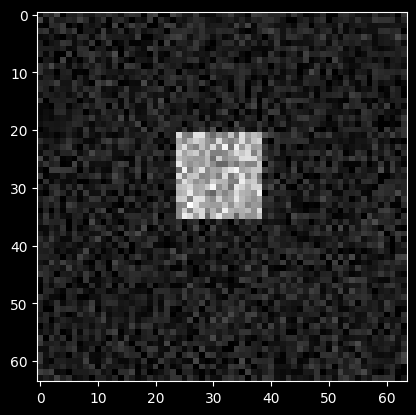

In [149]:
img, coord = dataset[2512]

print(f'Coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [150]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [151]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

#### Подготовка модели

In [170]:
class MyCNN_REGR(nn.Module):
    def __init__(self, size_in, out):
        super().__init__()

        # создаем слои, которые по сути являются последовательными моделями
        # слой 1 - сверточная модель
        self.conv = nn.Sequential(
            nn.Conv2d(size_in, 32, (3,3), bias=True),    # (batch_size, 1, 64, 64) => (batch_size, 32, 62, 62)
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), bias=True),    # (batch_size, 32, 62, 62) => (batch_size, 64, 60, 60)
            # nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # подготовка для линейной модели
        self.flatten = nn.Flatten()    # (batch_size, 64, 60, 60) => (batch_size, 64*60*60)
        
        # слой 2 - линейная модель
        self.line = nn.Sequential(
            nn.Linear(64*60*60, 128),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(128, out)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.line(x)
        return out

In [171]:
model_regression = MyCNN_REGR(1, 2).to(device)

In [172]:
# Проверяем правильность построения модели
input = torch.rand([16, 1, 64, 64], dtype=torch.float32).to(device)

out = model_regression(input)
out.shape

torch.Size([16, 2])

In [174]:
# выбираем функцию потерь. оптимизатор, шедулер, и контролируем остановку обучения
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model_regression.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)
earlystopping = EarlyStopping(mode='min', patience=10)

#### Тренировка модели

In [175]:
EPOCHS = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None

In [176]:
# Цикл обучения
for epoch in range(EPOCHS):

    start_time = time.time()  # Засекаем время начала тренировки модели

    # 1. Тренировка модели
    model_regression.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        # x = x.reshape(-1, 64*64).to(device)
        x = x.to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = model_regression(x)
        loss = loss_model(pred, targets)

        # - Обратный проход
        opt.zero_grad()
        loss.backward()
        # - Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")

        # Засекаем время конца обучения эпохи
        end_time = time.time()
        epoch_time = end_time - start_time
 
    # 2. Расчет значения метрики
    running_train_acc = true_answer / len(train_set)

    # 3. Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # 4. Проверка модели (Валидация)
    model_regression.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # - Данные
            # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
            # x = x.reshape(-1, 64*64).to(device)    # т.к. мы уже подаем данные, нам нет необходимости их вытягивать
            x = x.to(device)    # спокойно перекладываем вектор на cuda
            targets = targets.to(device)

            # - Прямой проход + расчет ошибки модели
            pred = model_regression(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        # 2. Расчет значения метрики
        running_val_acc = true_answer / len(val_set)

        # 3. Сохранение значения функции потерь и метрики    true_answer = 0

        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

    # добавляем две проверки, для сохранения лучшей модели
    if best_loss is None:
        best_loss = mean_val_loss
    # это самое простое условие, но это неприемлемо
    # if mean_val_loss < best_loss:
    #     best_loss = mean_val_loss
    # мы будем сохранять модель, чей лосс улучшился на ЗНАЧИМОЕ для нас значение
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss

        checkpoint = {
            'state_model': model.state_dict(),
            'state_opt': opt.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss':{
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric':{
                'train_acc': train_acc,
                'val_acc': val_acc
            },
            'lr': lr_list,
            'epoch':{
                'EPOCHS': EPOCHS,
                'save_epoch': epoch
            }
        }
        

        torch.save(checkpoint, f'model_reg_state_dict_epoch_{epoch+1}.pt')
        print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

    # здесь дописать комментарий
    if earlystopping(mean_val_loss):
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break

    # выводим время обучения одной эпохи
    print(f"Время на обучение модели в эпоху {epoch + 1}: {epoch_time:.2f} секунд.")

Epoch [1/100], train_loss=2.0131, train_acc=0.8940, val_loss=0.0600, val_acc=0.9774, lr=0.0001
Время на обучение модели в эпоху 1: 106.40 секунд.


Epoch [2/100], train_loss=0.0370, train_acc=0.9723, val_loss=0.0460, val_acc=0.9916, lr=0.0001
На эпохе: 2, сохранена модель со значением функции потерь на валидаци: 0.0460

Время на обучение модели в эпоху 2: 101.34 секунд.


Epoch [3/100], train_loss=0.0266, train_acc=0.9915, val_loss=0.0174, val_acc=0.9996, lr=0.0001
На эпохе: 3, сохранена модель со значением функции потерь на валидаци: 0.0174

Время на обучение модели в эпоху 3: 101.32 секунд.


KeyboardInterrupt: 

На третьей эпохе точность уже 99,96%, куда уж больше нужно то = ).

В общем нейронки - это конечно супер. Дальше будем развлекатсья в следующих ноутбуках)

Проверим сохраненную модель на Тестовой выборке!

In [178]:
# создаем новую модель
new_reg_model = MyCNN_REGR(1, 2).to(device)

In [179]:
# подгружаем состояние уже обученной
checkpoint = torch.load('model_reg_state_dict_epoch_3.pt')
new_reg_model.load_state_dict(checkpoint['state_model'])

/tmp/ipykernel_20726/477966897.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_reg_state_dict_epoch_3.pt')


RuntimeError: Error(s) in loading state_dict for MyCNN_REGR:
	Missing key(s) in state_dict: "conv.0.bias", "conv.2.weight", "conv.2.bias", "line.2.weight", "line.2.bias". 
	Unexpected key(s) in state_dict: "conv.4.weight", "conv.4.bias", "conv.4.running_mean", "conv.4.running_var", "conv.4.num_batches_tracked", "conv.1.weight", "conv.1.bias", "conv.1.running_mean", "conv.1.running_var", "conv.1.num_batches_tracked", "conv.3.weight", "line.3.weight", "line.3.bias". 
	size mismatch for conv.0.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for line.0.weight: copying a param with shape torch.Size([128, 36864]) from checkpoint, the shape in current model is torch.Size([128, 230400]).

Вот оно что!

Необходимо будет поправить код для корректного сохранения и загрузки модели CNN!

Но это уже в следующий раз=)